#### This notebook finds a static factorization of transition dynamics / SCM

In [2]:
import numpy as np
np.random.seed(123)
import torch
from structured_transitions import gen_samples_static, TransitionsData, MaskedNetwork

In [3]:
BATCH_SIZE = 250
MASK_REGULARIZATION_COEFFICIENT = 2e-3
WEIGHT_DECAY = 1e-4
SPLITS = [4, 3, 2] # this is the factorization
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

fns, samples = gen_samples_static(num_seqs=600, seq_len=10, splits=SPLITS) # 6000 datapoints
dataset = TransitionsData(samples)
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

In [4]:
model = MaskedNetwork(in_features=sum(SPLITS), out_features=sum(SPLITS), 
                      num_hidden_layers=2, num_hidden_units=256).to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
pred_criterion = torch.nn.MSELoss()
mask_criterion = torch.nn.L1Loss()

for epoch in range(100):
  total_pred_loss, total_mask_loss = 0., 0.
  for i, (x, y) in enumerate(train_loader):
    pred_y = model(x.to(dev))
    pred_loss = pred_criterion(y.to(dev), pred_y)
    mask = model.mask
    mask_loss = MASK_REGULARIZATION_COEFFICIENT*mask_criterion(torch.log(1.+mask), torch.zeros_like(mask))

    total_pred_loss += pred_loss
    total_mask_loss += mask_loss
    
    loss = pred_loss + mask_loss
    model.zero_grad()
    loss.backward()
    opt.step()
  if epoch % 10 == 0:
    print('Epoch {} done! Pred loss: {:.5f}, Mask loss: {:.5f}'.format(epoch, total_pred_loss / i, total_mask_loss / i))

Epoch 0 done! Pred loss: 0.00465, Mask loss: 0.00494
Epoch 10 done! Pred loss: 0.00029, Mask loss: 0.00095
Epoch 20 done! Pred loss: 0.00025, Mask loss: 0.00033
Epoch 30 done! Pred loss: 0.00022, Mask loss: 0.00021
Epoch 40 done! Pred loss: 0.00020, Mask loss: 0.00018
Epoch 50 done! Pred loss: 0.00019, Mask loss: 0.00017
Epoch 60 done! Pred loss: 0.00018, Mask loss: 0.00016
Epoch 70 done! Pred loss: 0.00018, Mask loss: 0.00016
Epoch 80 done! Pred loss: 0.00018, Mask loss: 0.00016
Epoch 90 done! Pred loss: 0.00017, Mask loss: 0.00015


In [5]:
m = model.mask.detach().cpu().numpy()
m[m < 0.05] = 0
m.round(2)

array([[0.06, 0.11, 0.17, 0.23, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.17, 0.18, 0.24, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.11, 0.21, 0.16, 0.29, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.14, 0.22, 0.21, 0.26, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.22, 0.3 , 0.27, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.26, 0.36, 0.36, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.26, 0.28, 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.09],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.14]],
      dtype=float32)

In [6]:
(m > 0).astype(np.int_)

array([[1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

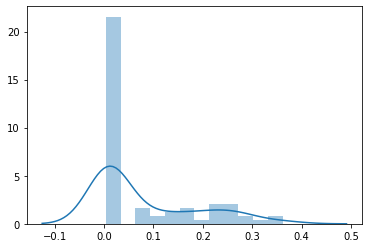

In [8]:
sns.distplot(model.mask.detach().cpu().numpy().reshape(-1), bins=12)

In [9]:
type(fns[0].f)
# fns[0].weight

torch.nn.modules.container.Sequential

In [10]:
import scipy
from sklearn import metrics
from typing import Tuple

Array = np.ndarray

def model_sparsity(model: MaskedNetwork, threshold: float) -> Array:
    assert isinstance(model, MaskedNetwork), 'bad model'
    mask = model.mask.detach().cpu().numpy()
    mask[mask < threshold] = 0
    mask = (mask > 0).astype(np.int_)
    return mask


def precision_recall(model: MaskedNetwork, threshold: float) -> Tuple[float, float]:
    predicted_sparsity = model_sparsity(model, threshold)
    ground_truth_sparsity = scipy.linalg.block_diag(*(
        np.ones((split, split), dtype=np.int_) for split in SPLITS
    ))
    precision = metrics.precision_score(
        ground_truth_sparsity.ravel(),
        predicted_sparsity.ravel()
    )
    recall = metrics.recall_score(
        ground_truth_sparsity.ravel(),
        predicted_sparsity.ravel()
    )
    return precision, recall

for tau in np.linspace(0., .3, 10):
    print(tau, precision_recall(model, tau))

0.0 (0.35802469135802467, 1.0)
0.03333333333333333 (1.0, 1.0)
0.06666666666666667 (1.0, 0.9655172413793104)
0.1 (1.0, 0.8620689655172413)
0.13333333333333333 (1.0, 0.7586206896551724)
0.16666666666666666 (1.0, 0.6551724137931034)
0.2 (1.0, 0.5517241379310345)
0.23333333333333334 (1.0, 0.3793103448275862)
0.26666666666666666 (1.0, 0.20689655172413793)
0.3 (1.0, 0.10344827586206896)


[0.35802469 0.35       0.34177215 0.33333333 0.32467532 0.31578947
 0.30666667 0.2972973  0.28767123 0.27777778 0.26760563 0.25714286
 0.24637681 0.23529412 0.2238806  0.21212121 0.2        0.1875
 0.17460317 0.16129032 0.14754098 0.13333333 0.11864407 0.10344828
 0.0877193  0.07142857 0.05454545 0.03703704 0.01886792 1.        ] [1.         0.96551724 0.93103448 0.89655172 0.86206897 0.82758621
 0.79310345 0.75862069 0.72413793 0.68965517 0.65517241 0.62068966
 0.5862069  0.55172414 0.51724138 0.48275862 0.44827586 0.4137931
 0.37931034 0.34482759 0.31034483 0.27586207 0.24137931 0.20689655
 0.17241379 0.13793103 0.10344828 0.06896552 0.03448276] [0.6383617  0.63895726 0.6974144  0.7102591  0.7189431  0.73186266
 0.7357404  0.7368525  0.7411412  0.74595535 0.76493204 0.7729171
 0.78153133 0.78242505 0.78623366 0.7919906  0.82197917 0.82653844
 0.8267417  0.83993393 0.85549366 0.86164284 0.8744736  0.88664013
 0.8902885  0.90677434 0.9117845  0.91474265 0.9350262  0.9708129
 0.9745938 

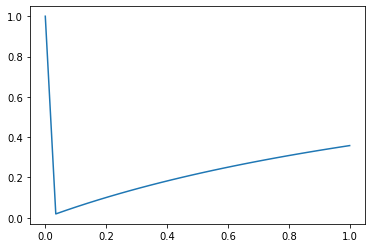

In [12]:
# plotting precision-recall doesn't work as expected
# (maybe b/c )

threshold = .1
predicted_sparsity = model_sparsity(model, threshold)
ground_truth_sparsity = scipy.linalg.block_diag(*(
    np.ones((split, split), dtype=np.int_) for split in SPLITS
))
mask = model.mask.detach().cpu().numpy()
p, r, t = metrics.precision_recall_curve(
    ground_truth_sparsity.ravel(),
    1. - mask.ravel()
)

print(p[p > 0.], r[r > 0.], t)

f, a = plt.subplots()
# a.plot(p[p > 0], r[p > 0])
a.plot(r[p > 0], p[p > 0])

# print(mask)